In [1]:
""" Retrieve the "baseline/pre-intervention files, and the test files"""
"""PRE-PT1, PRE-PT2, POST-PT"""

from google.cloud import storage
import scipy
from scipy import signal
from scipy.signal import find_peaks
import numpy as np
import os
import sys
import scipy.interpolate as interp
sys.path.append(os.path.join(sys.path[0], '..', 'src'))
import excel_reader_gcp as excel_reader
import gait_metrics as gait_metrics
from gait_metrics import *
import datetime
import logging   
import csv
import matplotlib.pyplot as plt
from hmmlearn import hmm
from sklearn.model_selection import train_test_split
import random
import pandas as pd
import re
import copy

def add_row_to_csv(csv_path, sensor_config, gait_param, algorithm, participant_num, level, parameter):
    # Define the header
    header = ['csv_path', 'sensor_config', 'trial_type', 'algorithm', 'participant_num', 'GPS level', 'Similarity/Deviation']
    
    # Check if the file exists
    file_exists = os.path.isfile(csv_path)
    
    with open(csv_path, mode='a', newline='') as file:
        writer = csv.writer(file)
        
        # If the file doesn't exist or is empty, write the header first
        if not file_exists or os.path.getsize(csv_path) == 0:
            writer.writerow(header)
        
        # Write the row data
        writer.writerow([csv_path, sensor_config, gait_param, algorithm, participant_num, level, parameter])

XsensGaitParser =  excel_reader.XsensGaitDataParser()
storage_client = storage.Client()
part_strides = {}
part_gait_params = {}
part_kinematic_params = {}
control_strides = {}
control_gait_params = {}
control_kinematic_params = {}

def reshape_vector(vectors_orig, new_size, num_axes=3):
    x_new = np.linspace(0, 100, new_size)
    trial_reshaped = []
    for stride in vectors_orig:
        x_orig = np.linspace(0, 100, len(stride))
        func_cubic = [interp.interp1d(x_orig, stride[:, i], kind='cubic') for i in range(num_axes)]
        vec_cubic = np.array([func_cubic[i](x_new) for i in range(num_axes)]).transpose()
        trial_reshaped.append(vec_cubic)
    return np.array(trial_reshaped)


bucket_dir = 'gs://gaitbfb_propellab/'
def compile_gait_data(store_gait_cycles, store_gait_params, store_kin_params, filenames, trial_type_filter, print_filenames=False, look_at_all_files = True, desired_filetypes=None):   

    XsensGaitParser = excel_reader.XsensGaitDataParser()  
    for i, file in enumerate(sorted(filenames)):
        trial_type = re.search(trial_type_filter, file).group(1)
        if(look_at_all_files or any(filetype in file for filetype in desired_filetypes)):
            XsensGaitParser.process_mvn_trial_data(os.path.join(bucket_dir, file))
            partitioned_mvn_data = XsensGaitParser.get_partitioned_mvn_data()
            gait_params = XsensGaitParser.get_gait_param_info()

            if trial_type in store_gait_cycles:
                for body_part in store_gait_cycles[trial_type]:
                    for i, side in enumerate(store_gait_cycles[trial_type][body_part]):
                        # for each part (pelvis, l_hip, r_knee, etc.), append strides to appropriate list
                        store_gait_cycles[trial_type][body_part][i] = store_gait_cycles[trial_type][body_part][i] + partitioned_mvn_data[body_part][i]

                store_gait_params[trial_type].append(gait_params['spatio_temp'])

                for joint in store_kin_params[trial_type]:
                    for i, side in enumerate(store_kin_params[trial_type][joint]):
                        store_kin_params[trial_type][joint][i] = np.append(store_kin_params[trial_type][joint][i], gait_params['kinematics'][joint][i], axis=0)

            else:
                store_gait_cycles[trial_type] = partitioned_mvn_data
                store_gait_params[trial_type] = [gait_params['spatio_temp']]
                store_kin_params[trial_type] = gait_params['kinematics']


bucket_name = 'gaitbfb_propellab/'
base_directory = bucket_name + 'Wearable Biofeedback System (REB-0448)/Data/Raw Data'
bucket_name = 'gaitbfb_propellab'
prefix = 'control_dir'
control_dir = 'Gait Quality Analysis/Data/Participant_Data/Processed Data/AbleBodied_Control/CSV'
blobs = storage_client.list_blobs(bucket_name, prefix = control_dir)
control_files = []
for blob in blobs:
    if('.csv' in blob.name):
        control_files.append(blob.name)

compile_gait_data(control_strides, control_gait_params, control_kinematic_params, control_files, 'CSV/(.*?)-00')        

aggregate_control_data = {}
strides_per_control = 10
for i, indiv in enumerate(control_strides.keys()):
    indices = np.arange(len(control_strides[indiv]['gyro_data'][0]))
    np.random.shuffle(indices)
    #control_strides_per_part.append(min(strides_per_control, len(indices)))
    
    if(i == 0):
        aggregate_control_data = control_strides[indiv]
        
        for signal_type in control_strides[indiv]:
            for j, side in enumerate(control_strides[indiv][signal_type]):
                aggregate_control_data[signal_type][j] = [control_strides[indiv][signal_type][j][indices[k]] for k in range(min(strides_per_control, len(indices))) ]
                    
                    
    else:
        # randomly sample 10 gait cycles from each able-bodied in control, or all gait cycles if less than 10
        for signal_type in control_strides[indiv]:
            for j, side in enumerate(control_strides[indiv][signal_type]):
                aggregate_control_data[signal_type][j] = aggregate_control_data[signal_type][j] + [control_strides[indiv][signal_type][j][indices[k]] 
                                                                                                for k in range(min(strides_per_control, len(indices))) ]

# reshape all the kinematic signals to the size specified for the GPS (51, e.g. 2% increments across the gait cycles from HS to HS)
# store in partitioned_awinda_control
partitioned_awinda_control = {}
partitioned_awinda_control['pelvis_orient'] = reshape_vector(aggregate_control_data['pelvis_orient'][0], new_size = 51)
partitioned_awinda_control['hip_angle'] = [reshape_vector(aggregate_control_data['hip_angle'][0], new_size = 51), reshape_vector(aggregate_control_data['hip_angle'][1], new_size = 51)]
partitioned_awinda_control['knee_angle'] = [reshape_vector(aggregate_control_data['knee_angle'][0], new_size = 51), reshape_vector(aggregate_control_data['knee_angle'][1], new_size = 51)]
partitioned_awinda_control['ankle_angle'] = [reshape_vector(aggregate_control_data['ankle_angle'][0], new_size = 51), reshape_vector(aggregate_control_data['ankle_angle'][1], new_size = 51)]


b20, a20 = scipy.signal.butter(N=4, Wn = 0.8, btype = 'lowpass')  # Wn = 0.8 = 40 / Nyquist F = 50Hz

def calculate_state_correspondence_matrix(hmm_1, hmm_2, n_states):
    def calculate_stationary_distribution(hmm):
        eigenvals, eigenvectors = np.linalg.eig(hmm.model.transmat_.T)
        stationary = np.array(eigenvectors[:, np.where(np.abs(eigenvals - 1.) < 1e-8)[0][0]])
        stationary = stationary / np.sum(stationary)
        return np.expand_dims(stationary.real, axis=-1)

    # KL-Divergence = method for determining the difference between two probability distributions
    def calculate_KL_div(hmm_model_1, hmm_model_2, state_model_1, state_model_2):
        means_1 = np.expand_dims(hmm_model_1.means_[state_model_1], axis=-1)
        means_2 = np.expand_dims(hmm_model_2.means_[state_model_2], axis=-1)

        covars_1 = hmm_model_1.covars_[state_model_1]
        covars_2 = hmm_model_2.covars_[state_model_2]

        term_1 = (means_2 - means_1).T @ np.linalg.inv(covars_2) @ (means_2 - means_1)
        term_2 = np.trace(np.linalg.inv(covars_2) @ covars_1)
        term_3 = np.log(np.linalg.det(covars_1) / np.linalg.det(covars_2))
        term_4 = len(covars_1)

        kl_divergence = 0.5 * (term_1 + term_2 - term_3 - term_4)

        return kl_divergence

    kl_state_comparisons = np.zeros((n_states, n_states))
    pi_1 = calculate_stationary_distribution(hmm_1)
    pi_2 = calculate_stationary_distribution(hmm_2)
    total_expected_similarity = 0

    for i in range(n_states):
        for j in range(n_states):
            kl_state_comparisons[i,j] = 0.5 * (calculate_KL_div(hmm_1.model, hmm_2.model, i, j) + calculate_KL_div(hmm_2.model, hmm_1.model, i, j))
            total_expected_similarity = total_expected_similarity + (pi_1[i] * pi_2[j] * kl_state_comparisons[i,j])

    k = 1

    # alternative methods of calculating similarity based on KL-Divergence
    # s_e = np.exp(-k * kl_state_comparisons)
    s_e = 1 / kl_state_comparisons

    # pi_1.T @ pi_2 should produce a N x N matrix (pi_1i * pi_2j)
    q_matrix = ((pi_1 @ pi_2.T) * s_e) / total_expected_similarity

    return q_matrix

def calculate_gini_index(q_matrix, n_states):
    def calc_gini(vector):
        vector = np.sort(vector)
        l1_norm = np.linalg.norm(vector, 1)
        a = 0
        for i in range(1, n_states+1):
            a = a + (vector[i-1] / l1_norm) * ((n_states - i + 0.5) / (n_states - 1))

        vec_sparsity = (n_states / (n_states - 1)) - (2 * a)

        return vec_sparsity

    # calculate mean sparsity of each row vector (r) and column vector (c) in Q matrix
    r = (1 / n_states) * np.sum([calc_gini(row) for row in q_matrix])
    c = (1 / n_states) * np.sum([calc_gini(column) for column in q_matrix.T])

    gini_index = 0.5 * (r + c)
    return gini_index


def reshape_vector(vectors_orig, new_size, num_axes=3):
    x_new = np.linspace(0, 100, new_size)
    trial_reshaped = []
    for stride in vectors_orig:
        x_orig = np.linspace(0, 100, len(stride))
        func_cubic = [interp.interp1d(x_orig, stride[:, i], kind='cubic') for i in range(num_axes)]
        vec_cubic = np.array([func_cubic[i](x_new) for i in range(num_axes)]).transpose()
        trial_reshaped.append(vec_cubic)
    return np.array(trial_reshaped)

def normalize_signal(signal):
    #print(np.shape(signal))
    mean = np.mean(signal, axis=1, keepdims=True)
    #print(np.shape(mean))
    std_dev = np.std(signal, axis=1, ddof=1, keepdims=True)
    normalized_signal = (signal - mean) / std_dev
    return normalized_signal

#uses dictionaries to extract the relevant raw sensor data, reshapes the data, then concatenates gyro and accelerometer signals together 
def organize_signals(sensor_mappings, gyro_signal, accel_signal):
    combined_signals = {}
    for location, sensor in sensor_mappings.items():
        reshaped_gyro = reshape_vector(gyro_signal[sensor], 40, 3)
        reshaped_accel = reshape_vector(accel_signal[sensor], 40, 3)
        
        normalized_gyro = normalize_signal(reshaped_gyro)
        normalized_accel = normalize_signal(reshaped_accel)
        
        # Concatenate the normalized gyro and accel signals
        combined_signals[location] = np.concatenate((normalized_gyro, normalized_accel), axis=2)
        # #combined_signals[location] = reshaped_gyro
        #combined_signals[location] = np.concatenate((reshaped_gyro, reshaped_accel), axis=2) #Concatenates to gyro x,y,z and accel x,y,z
    return combined_signals

import random 

def split_and_match_lists_with_params(list1, list2, GPS_list1, GPS_list2, max_size=None):
    # Convert inputs to lists to ensure proper handling
    list1, list2 = list(list1), list(list2)
    GPS_list1, GPS_list2 = list(GPS_list1), list(GPS_list2)

    if max_size > len(list1) // 2:
        if len(list1) // 2 > (max_size  - 5):
            max_size = len(list1) // 2
    # Set max_size to the minimum size possible for an even split if not specified
    if max_size is None:
        max_size = min(len(list1) // 2, len(list2))

    # Randomly split list1 and GPS_list1 into two groups of max_size
    list1_indices = random.sample(range(len(list1)), 2 * max_size)
    list1_part1 = [list1[i] for i in list1_indices[:max_size]]
    list1_part2 = [list1[i] for i in list1_indices[max_size:]]
    GPS_list1_part1 = [GPS_list1[i] for i in list1_indices[:max_size]]
    GPS_list1_part2 = [GPS_list1[i] for i in list1_indices[max_size:]]

    # Randomly sample list2 and GPS_list2 to match the max_size
    list2_indices = random.sample(range(len(list2)), max_size)
    list2_sampled = [list2[i] for i in list2_indices]
    GPS_list2_sampled = [GPS_list2[i] for i in list2_indices]

    return (list1_part1, list1_part2, list2_sampled), (GPS_list1_part1, GPS_list1_part2, GPS_list2_sampled)

    
XsensGaitParser =  excel_reader.XsensGaitDataParser()
storage_client = storage.Client()
bucket_name = 'gaitbfb_propellab/'
base_directory = bucket_name + 'Gait Quality Analysis/Data/Participant_Data/Raw Data/LLA_xsens/PT Protocol Data'
bucket_name = 'gaitbfb_propellab'
blobs = storage_client.list_blobs(bucket_name, prefix = base_directory)
prefix_from_bucket = 'Gait Quality Analysis/Data/Participant_Data/Raw Data/LLA_xsens/PT Protocol Data/'


script_dir = 'C:\\GP-WearablesAnalysis\\examples'
current_datetime = datetime.datetime.now().strftime('%Y-%m-%d_%H-%M-%S')
run_time = datetime.datetime.now().strftime("%d-%m-%y_%H-%M")
csv_filename = f"PTlogresults_{run_time}.csv" #Builds a log file based on the current time to keep track of runs
csv_path = os.path.join(script_dir, csv_filename)
log_file = f'C:\\GP-WearablesAnalysis\\examples\\log_{run_time}.txt'
logging.basicConfig(filename=log_file, level=logging.INFO, format='%(asctime)s - %(message)s')

#participant_list = ['LLA1','LLA2','LLA3','LLA4','LLA5','LLA6','LLA7','LLA8','LLA10','LLA11','LLA12','LLA13','LLA14','LLA15','LLA16']
#participant_list = ['LLA1','LLA2','LLA3','LLA4','LLA5','LLA10','LLA11','LLA12','LLA13','LLA14','LLA15','LLA16']
participant_list = ['LLA10']
#participant_list = ['LLA1']

#Dictionary to map the sensor locations to their IDs.
sensor_mappings = {
    'pelvis': 1,
    'UpperR': 2,
    'LowerR': 3,
    'UpperL': 5,
    'LowerL': 6
}

for participant in participant_list:
    print(f"processing participant {participant}")
    directory = prefix_from_bucket + participant + '/CSV'
    blobs = storage_client.list_blobs(bucket_or_name=bucket_name, prefix=directory.replace("\\", "/"))
    part_strides = {}
    part_gait_params = {}
    part_kinematic_params = {}
    part_sensor_data = {}
    gait_scores_list = {}

    logging.info(f"Processing participant {participant} - ONLY GYRO DATA")
    if blobs:
        for blob in blobs:
            if blob.name.endswith('.csv'):
                file_name = os.path.basename(blob.name)

                # Determine whether the file is "pre" or "post"
                if "Pre" in file_name or "Baseline" in file_name:
                    trial_type = "Pre"
                elif "Post" in file_name:
                    trial_type = "Post"
                else:
                    continue  # Skip files that don't match "Pre" or "Post"
                
                
                XsensGaitParser.process_mvn_trial_data(f"gs://{bucket_name}/{blob.name}")
                partitioned_mvn_data = XsensGaitParser.get_partitioned_mvn_data()
                gait_params = XsensGaitParser.get_gait_param_info()
                combined_signals = organize_signals(sensor_mappings, partitioned_mvn_data['gyro_data'], partitioned_mvn_data['acc_data'])
                pelvis_data = combined_signals['pelvis']
                upper_data = np.concatenate((combined_signals['UpperR'], combined_signals['UpperL']),axis=2)
                lower_data = np.concatenate((combined_signals['LowerR'], combined_signals['LowerL']), axis=2)
                
            
                file_name = os.path.basename(blob.name)
                if trial_type not in part_sensor_data:
                    part_sensor_data[trial_type] = {'pelvis':[], 'Upper': [], 'Lower': []}
                                
                if trial_type in part_strides:
                    for body_part in part_strides[trial_type]:
                        for i, side in enumerate(part_strides[trial_type][body_part]):
                            # for each part (pelvis, l_hip, r_knee, etc.), append strides to appropriate list
                            part_strides[trial_type][body_part][i] = part_strides[trial_type][body_part][i] + partitioned_mvn_data[body_part][i]
                            
                    part_gait_params[trial_type].append(gait_params['spatio_temp'])
                    part_sensor_data[trial_type]['pelvis'] = np.append(part_sensor_data[trial_type]['pelvis'], pelvis_data,axis=0)
                    part_sensor_data[trial_type]['Upper'] = np.append(part_sensor_data[trial_type]['Upper'], upper_data,axis=0)
                    part_sensor_data[trial_type]['Lower'] = np.append(part_sensor_data[trial_type]['Lower'], lower_data,axis=0)
                    
                    for joint in part_kinematic_params[trial_type]:
                        for i, side in enumerate(part_kinematic_params[trial_type][joint]):
                            part_kinematic_params[trial_type][joint][i] = np.append(part_kinematic_params[trial_type][joint][i], gait_params['kinematics'][joint][i], axis=0) 

                else:
                    part_strides[trial_type] = partitioned_mvn_data
                    part_gait_params[trial_type] = [gait_params['spatio_temp']]
                    part_kinematic_params[trial_type] = gait_params['kinematics']
                    part_sensor_data[trial_type]['pelvis'] = pelvis_data
                    part_sensor_data[trial_type]['Upper'] =  upper_data
                    part_sensor_data[trial_type]['Lower'] = lower_data
                    
                file_name = os.path.basename(blob.name)
    
    
    trial_types = ['Pre','Post']       
       
    for trial_type in trial_types:
        partitioned_awinda_gait = {
            trial_type: {
                'pelvis_orient': reshape_vector(part_strides[trial_type]['pelvis_orient'][0], new_size=51),
                'hip_angle': [
                    reshape_vector(part_strides[trial_type]['hip_angle'][0], new_size=51),
                    reshape_vector(part_strides[trial_type]['hip_angle'][1], new_size=51)
                ],
                'knee_angle': [
                    reshape_vector(part_strides[trial_type]['knee_angle'][0], new_size=51),
                    reshape_vector(part_strides[trial_type]['knee_angle'][1], new_size=51)
                ],
                'ankle_angle': [
                    reshape_vector(part_strides[trial_type]['ankle_angle'][0], new_size=51),
                    reshape_vector(part_strides[trial_type]['ankle_angle'][1], new_size=51)
                ]
            }
        }

        individual_signals = []
        gait_scores_list[trial_type] = []

        for i in range(partitioned_awinda_gait[trial_type]['pelvis_orient'].shape[0]):
            signal_dict = {
                'pelvis_orient': partitioned_awinda_gait[trial_type]['pelvis_orient'][i].reshape(1, 51, 3),
                'hip_angle': [
                    partitioned_awinda_gait[trial_type]['hip_angle'][0][i].reshape(1, 51, 3),
                    partitioned_awinda_gait[trial_type]['hip_angle'][1][i].reshape(1, 51, 3)
                ],
                'knee_angle': [
                    partitioned_awinda_gait[trial_type]['knee_angle'][0][i].reshape(1, 51, 3),
                    partitioned_awinda_gait[trial_type]['knee_angle'][1][i].reshape(1, 51, 3)
                ],
                'ankle_angle': [
                    partitioned_awinda_gait[trial_type]['ankle_angle'][0][i].reshape(1, 51, 3),
                    partitioned_awinda_gait[trial_type]['ankle_angle'][1][i].reshape(1, 51, 3)
                ]
            }
            individual_signals.append(signal_dict)

        for signal_val in individual_signals:
            gait_scores = calc_gait_profile_score(signal_val, partitioned_awinda_control)
            gait_scores_list[trial_type].append(gait_scores)
        
    ##Group formation
    sensors = ['pelvis', 'Upper', 'Lower']
    print(len(list(gait_scores_list['Pre'])))
    print(len(list(gait_scores_list['Post'])))
    
        
    # for sensor_loc in sensors:
        
    #     (Pre_PT1, Pre_PT2, Post_PT), (Pre_PT1_GPS, Pre_PT2_GPS, Post_PT_GPS) =split_and_match_lists_with_params(part_sensor_data['Pre'][sensor_loc], part_sensor_data['Post'][sensor_loc],gait_scores_list['Pre'], gait_scores_list['Post'],max_size=50)
        

    #     logging.info(f"Group size: {len(Pre_PT1)}")
    #     raw_sensor = [Pre_PT1, Pre_PT2, Post_PT]
    #     GPS_score = [Pre_PT1_GPS,Pre_PT2_GPS, Post_PT_GPS]
        
    #     fig, axes = plt.subplots(6, 1, figsize=(10, 15), sharex=True, sharey=True)
        
    #     Pre_PT1 = np.array(Pre_PT1)
    #     Post_PT = np.array(Post_PT)
    #     # Plot each axis in a separate subplot
    #     for i in range(6):
    #         excel_reader.visualize_strides(Pre_PT1[:,:,i], axes[i], i, 0, confidence_plot=True)  # Adjust the trial_num as needed
    #         excel_reader.visualize_strides(Post_PT[:,:,i], axes[i], i, 1, confidence_plot=True)
        


c:\Users\ekuep\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Users\ekuep\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
c:\Users\ekuep\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Users\ekuep\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
c:\Users\ekuep\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=

processing participant LLA10
179
108


(4320, 12)


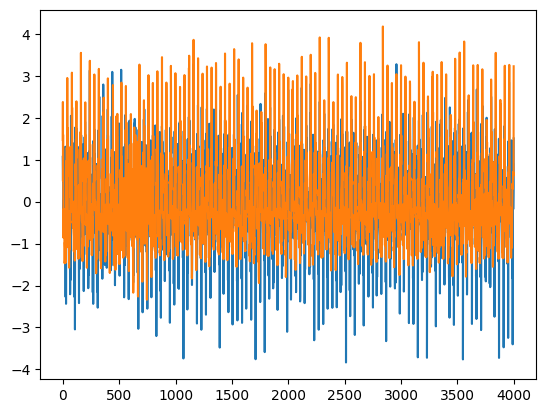

In [47]:
Pre_PT = np.array(part_sensor_data['Pre']['Upper'])
Pre_PT = Pre_PT.reshape(Pre_PT.shape[0]*Pre_PT.shape[1],Pre_PT.shape[-1])
Post_PT = np.array(part_sensor_data['Post']['Upper'])
Post_PT = Post_PT.reshape(Post_PT.shape[0]*Post_PT.shape[1],Post_PT.shape[-1])
print(np.shape(Post_PT))
plt.figure()
plt.plot(Post_PT[:4000,1])   
plt.plot(Pre_PT[:4000,1])
   

In [14]:
import os
def rename_files_in_folder(folder_path):
    # Iterate over all files in the folder
    for filename in os.listdir(folder_path):
        # Construct the old file path
        old_file_path = os.path.join(folder_path, filename)
        
        # Check if it's a file
        if os.path.isfile(old_file_path):
            # Check if the filename starts with "TA"
            if filename.startswith("TA"):
                # Remove the old "TA" prefix and add "TA_" prefix
                new_filename = "TA_" + filename[2:]
                new_file_path = os.path.join(folder_path, new_filename)
                
                # Rename the file
                os.rename(old_file_path, new_file_path)
                print(f'Renamed: {old_file_path} -> {new_file_path}')

# Specify the path to your folder here
folder_path = r'Q:\gaitbfb_propellab\Gait Quality Analysis\Data\Participant_Data\Raw Data\LLA_xsens\PT Protocol Data\LLA10\CSV'
rename_files_in_folder(folder_path)

Renamed: Q:\gaitbfb_propellab\Gait Quality Analysis\Data\Participant_Data\Raw Data\LLA_xsens\PT Protocol Data\LLA10\CSV\TABaseline-001_3700-5030.csv -> Q:\gaitbfb_propellab\Gait Quality Analysis\Data\Participant_Data\Raw Data\LLA_xsens\PT Protocol Data\LLA10\CSV\TA_Baseline-001_3700-5030.csv
Renamed: Q:\gaitbfb_propellab\Gait Quality Analysis\Data\Participant_Data\Raw Data\LLA_xsens\PT Protocol Data\LLA10\CSV\TABaseline-001_7024-8303.csv -> Q:\gaitbfb_propellab\Gait Quality Analysis\Data\Participant_Data\Raw Data\LLA_xsens\PT Protocol Data\LLA10\CSV\TA_Baseline-001_7024-8303.csv
Renamed: Q:\gaitbfb_propellab\Gait Quality Analysis\Data\Participant_Data\Raw Data\LLA_xsens\PT Protocol Data\LLA10\CSV\TABaseline-001_88-1531.csv -> Q:\gaitbfb_propellab\Gait Quality Analysis\Data\Participant_Data\Raw Data\LLA_xsens\PT Protocol Data\LLA10\CSV\TA_Baseline-001_88-1531.csv
Renamed: Q:\gaitbfb_propellab\Gait Quality Analysis\Data\Participant_Data\Raw Data\LLA_xsens\PT Protocol Data\LLA10\CSV\TABas

In [6]:
print(np.shape(Pre_PT1))
print(np.std(Pre_PT1[1,:,1]))

(50, 40, 12)
1.0


In [ ]:
        """ DTW Implementation"""
        print(f"Sensor arrangement: {sensor_loc}")
        dtw_mean_distances = []
        
        for j in range(1, len(raw_sensor)):
            dtw_between = tslearn_dtw_analysis(set1 = raw_sensor[0], set2 = raw_sensor[j]) # type: ignore
            dtw_mean_distances.append(dtw_between)
            add_row_to_csv(csv_path, sensor_loc,'PT', 'DTW', participant, np.mean(GPS_score[j]), dtw_between)
        print(dtw_mean_distances) 
        
        """ SOM Implementation"""
        random.shuffle(raw_sensor[0])
        train_data = np.concatenate(raw_sensor[0],axis=0)
        print("Training Data Shape:", train_data.shape)
        print("Training the SOM on baseline data")
        MDP_mean_deviations = []
        trained_SOM = train_minisom(train_data, learning_rate=0.1, topology='hexagonal', normalize=True) # type: ignore
        
        for j in range(1, len(raw_sensor)):
            #Shuffle and split the list (only looking at the test data here)
            random.shuffle(raw_sensor[j])
            test_data = np.concatenate(raw_sensor[j],axis=0)
            MDP_scores = calculate_MDP(test_data, train_data, trained_SOM, normalize=True) # type: ignore
            MDP_mean_deviations.append(np.mean(MDP_scores))
            add_row_to_csv(csv_path, sensor_loc,'PT','MDP',participant, np.mean(GPS_score[j]), np.mean(MDP_scores))
        
        print(f"MDP mean deviations: {MDP_mean_deviations}")
        
        #Implementing the HMM
        strides_train_flat = {}
        strides_test_flat = {}
        strides_train = {}
        strides_test = {}
        resize_len = 40
        strides_to_concat = 10
        num_states= 3 #Changed from 5 to 2 #Test 3 as well 
        train_iterations = 300 
        train_tolerance = 1e-2
        num_models_train = 10
        concat_strides = {}

        for idx, group in enumerate(raw_sensor):
            concat_strides[idx] = []
            group = np.array(group)
            for i in range(group.shape[0] - strides_to_concat):
                temp = []
                for j in range(strides_to_concat):
                    temp.append(group[i + j])
                concat_strides[idx].append(np.concatenate(temp, axis=0))

            concat_strides[idx] = np.array(concat_strides[idx])
            concat_strides[idx] = signal.filtfilt(b20, a20, concat_strides[idx], axis=1)
            
        hmm_models = {}  
            
        for idx, group in enumerate(raw_sensor):
            
            num_models_training = num_models_train #Re initialize the number of models for training 
            hmm_models[idx] = []
            
            for j in range(num_models_training):
                train_forward_model = True
                k = 0
                
                while(train_forward_model):
                    print('Train Attempt ', k+1, end="\r", flush=True)
                    
                    if(j > -1):
                        np.random.shuffle(concat_strides[idx])
                        
                    # flatten sequence for hmmlearn train function
                    strides_sequence_flattened = concat_strides[idx].reshape((concat_strides[idx].shape[0] * concat_strides[idx].shape[1], -1))
                    
                    # technically is no training/testing data, but this preserves a few gait cycles to compare the hidden-state sequence predictions of the HMMs
                    len_train = int(0.95 * len(concat_strides[idx]))
                    strides_train[idx] = concat_strides[idx][:len_train]
                    strides_test[idx] = concat_strides[idx][len_train:]
                    sequence_length = resize_len * strides_to_concat
                    strides_train_flat[idx] = strides_sequence_flattened[:sequence_length * len_train]
                    strides_test_flat[idx] = strides_sequence_flattened[sequence_length * len_train:]

                    hmm_model = HMMTrainer(n_components = num_states, n_iter = train_iterations, tolerance = train_tolerance)
                    hmm_model.train(strides_train_flat[idx], sequence_length, len_train)


                    # double checks for left-to-right architecture in transition matrix
                    valid_rows = 0
                    a_mat = hmm_model.model.transmat_
                    for i, row in enumerate(a_mat):
                        temp = np.argpartition(np.roll(row, -i), -2)[-2:]
                        if((np.array(temp) == np.array([0,1])).all() or (np.array(temp) == np.array([1,0])).all()):
                            valid_rows = valid_rows + 1

                    # correct_second_state = [i for i in range(num_states - 1)]
                    # correct_second_state.append(0)        
                    # for i, row in enumerate(hmm_model.model.transmat_):
                    #     max_state = np.argmax(row)
                    #     if(max_state == i):
                    #         temp = [j for j in row if not (j == row[max_state])]
                    #         if(np.argmax(temp) == correct_second_state[i]):
                    #             valid_rows = valid_rows + 1

                    #if model is left-to-right, consider model trained, train next model (until num_models_train reached)
                    
                    if(valid_rows == num_states):
                        train_forward_model = False
                    k = k + 1
                hmm_models[idx].append(hmm_model)

        print('done')
        
        test_predict = strides_test[0][1] #2nd element of idx = 0
        min_predict = np.min(test_predict[:,1])
        max_predict = np.max(test_predict[:,1])
        
        
        def align_states(trained_hmm_model, roll_amount=0):
            new_hmm = copy.deepcopy(trained_hmm_model)
            array_order = np.roll(np.arange(num_states), roll_amount)

            new_hmm.model.transmat_ = new_hmm.model.transmat_[array_order,: ]
            for i, row in enumerate(new_hmm.model.transmat_):
                new_hmm.model.transmat_[i] = np.roll(new_hmm.model.transmat_[i], roll_amount)

            new_hmm.model.means_ = new_hmm.model.means_[array_order, :]
            new_hmm.model.covars_ = new_hmm.model.covars_[array_order, :]
            new_hmm.model.startprob_ = new_hmm.model.startprob_[array_order]
            return new_hmm 

        pred_vals = np.ones(num_states)
        
        for state in range(num_states):
            pred_vals[state] = min_predict + ((state * (max_predict - min_predict)) / (num_states - 1))

        roll_amounts = {}
        match_trials = {}

        for idx, group in enumerate(raw_sensor):
            roll_amounts[idx] = [0 for i in range(num_models_train)]
            match_trials[idx] = 0

        shift_all = 0

        def find_best_alignment(hmm_1, hmm_2, test_stride, n_states):
            min_distance = 9999999
            best_roll = 0

            for j in range(n_states):
                new_hmm = align_states(hmm_2, j)
                prediction_1 = hmm_1.model.predict(test_stride)
                prediction_2 = new_hmm.model.predict(test_stride)

                distance = np.sum((prediction_1 - prediction_2) ** 2)
                if (distance < min_distance):
                    min_distance = distance
                    best_roll = j

            return best_roll

        predictions = {}
        hmm_models_aligned_states = {}
        
        for idx, group in enumerate(raw_sensor):
            
            predictions[idx] = []
            hmm_models_aligned_states[idx] = []
            match_trials[idx] = find_best_alignment(hmm_models[0][0], hmm_models[idx][0], test_predict, num_states)
            
            roll_amounts[idx] = [0] * len(hmm_models[idx]) #Can now handle different lengths of trained models 
            
            for j in range(len(hmm_models[idx])):
                roll_amounts[idx][j] = find_best_alignment(hmm_models[idx][0], hmm_models[idx][j], test_predict, num_states) + match_trials[idx]
                # roll_amounts[idx][j] = 0
                hmm_models_aligned_states[idx].append(align_states(hmm_models[idx][j], roll_amounts[idx][j] + shift_all))
                predictions[idx].append(hmm_models_aligned_states[idx][-1].model.predict(test_predict))

        symmranges = []
        mean_difs = []
                
        if num_models_train == 1:
            for j, group in enumerate(raw_sensor):
                sum_dif = 0
                count = 0
                if (j == 0):
                    m = 1 #only want the other trained model
                else:
                    m = 0
                x = calculate_state_correspondence_matrix(hmm_models_aligned_states[0][0], hmm_models_aligned_states[j][m], num_states)
                sum_dif = sum_dif + calculate_gini_index(x, num_states)
                # log HMM-SM similarity
                # print('%s - %s  :  %.5f' % (ordered_group_means[0], ordered_group_means[j], sum_dif))
                # symmrange = '%s - %s' % (ordered_group_means[0], ordered_group_means[j])
                # add_row_to_csv(csv_path, arrangements[sensor_idx],'GPS','HMM-SM',participant, symmrange, sum_dif)
                
        else: #If averaging a larger set (multiple HMMs trained)
            # i and j iterate over the trial types.
            # compare all permutations between HMMs in trial_types[i] and trial_types[j] to compute a mean HMM-SM similarity
            # between the two symmetry ranges. If i and j are the same (e.g., comparing within a symmetry range), don't compare
            # HMM to itself
            for j, group in enumerate(raw_sensor):
                sum_dif = 0
                count = 0
                for k in range(num_models_train):
                    if(j == 0): #Always comparing to the first group, so if j (other group is same as baseline, make sure it is testing against )
                        indices = [a for a in range(num_models_train) if (not a == k)]
                    else:
                        indices = np.arange(num_models_train)
                    for m in indices:
                        x = calculate_state_correspondence_matrix(hmm_models_aligned_states[0][k], hmm_models_aligned_states[j][m], num_states)
                        sum_dif = sum_dif + calculate_gini_index(x, num_states)
                        count = count+1

                # log average HMM-SM similarity
                mean_dif = sum_dif / count
                print(count)
                print(mean_dif)
                # print('%s - %s  :  %.5f' % (ordered_group_means[0], ordered_group_means[j], mean_dif))
                symmrange = '%s - %s' % (round(np.mean(GPS_score[0]),3), round(np.mean(GPS_score[j]),3))
                # symmranges.append(symmrange)
                # mean_difs.append(mean_dif)
                add_row_to_csv(csv_path, sensor_loc,'PT','HMM-SM',participant, symmrange, mean_dif)